In [143]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.major.pad']='16'

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session



In [144]:
code_length = 10
output_image = 32

data = np.random.choice([-1, 1], size=(20000, 10))
input_data = data[0:18000]
val_data = data[-2000:]

In [145]:
try:
    reduce
except NameError:
    from functools import reduce

tf.reset_default_graph()
sess = get_session()

In [146]:
# # preload vgg network

# import vgg

# STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')
# style_images = [plt.imread(style) for style in ['style.jpg']]

# style_shapes = [(1,) + style.shape for style in style_images]
# style_features = [{} for _ in style_images]
# style_weight = 5e2
# vgg_weights, vgg_mean_pixel = vgg.load_net("../neural-style/imagenet-vgg-verydeep-19.mat")

# layer_weight = 1.0
# style_layer_weight_exp = 1.0
# style_layers_weights = {}
# for style_layer in STYLE_LAYERS:
#     style_layers_weights[style_layer] = layer_weight
#     layer_weight *= style_layer_weight_exp
    
# # normalize style layer weights
# layer_weights_sum = 0
# for style_layer in STYLE_LAYERS:
#     layer_weights_sum += style_layers_weights[style_layer]
# for style_layer in STYLE_LAYERS:
#     style_layers_weights[style_layer] /= layer_weights_sum
    
# for i in range(len(style_images)):
#     g = tf.Graph()
#     with g.as_default(), g.device('/gpu:0'), tf.Session() as sess:
#         image = tf.placeholder('float', shape=style_shapes[i])
#         net = vgg.net_preloaded(vgg_weights, image, 'max')
#         print(image.shape)
#         style_pre = np.array([vgg.preprocess(style_images[i], vgg_mean_pixel)])
#         for layer in STYLE_LAYERS:
#             print(net[layer].shape)
#             features = net[layer].eval(feed_dict={image: style_pre})
#             features = np.reshape(features, (-1, features.shape[3]))
#             gram = np.matmul(features.T, features) / features.size
#             style_features[i][layer] = gram



In [147]:


# synthesizer network
input_ = tf.placeholder(tf.float32, [None, code_length])
isTraining = tf.placeholder(tf.bool)

dense_layer = tf.layers.dense(input_, output_image * output_image * 3, activation=tf.nn.relu, name='dense1')
# bn_1 = tf.layers.batch_normalization(dense_layer, axis=1, training=isTraining)

# dense_2 = tf.layers.dense(bn_1, 7 * 7 * 128, activation=tf.nn.relu)
# bn_2 = tf.layers.batch_normalization(dense_2, axis=1, training=True)
# bn_2 = tf.reshape(bn_2, (-1, 7, 7, 128))

# # [N, 7, 7, 128] x [4, 4] = [N, 14, 14, 64]
# tconv2d_1 = tf.layers.conv2d_transpose(bn_2, 64, 4, 2, padding="same", activation=tf.nn.relu)
# bn_3 = tf.layers.batch_normalization(tconv2d_1, axis=3, training=True)

# # [N, 14, 14, 64] x [4, 4] = [N, 28, 28, 1]
# dense_layer1 = tf.layers.conv2d_transpose(bn_3, 3, 6, 2, padding="valid", activation=tf.sigmoid)
dense_layer1 = tf.reshape(dense_layer, (-1, output_image, output_image, 3))
tf.summary.image('marker', dense_layer1)

#recognizer network
conv1 = tf.layers.conv2d(dense_layer1, 96, [5, 5], padding='same', name='conv1') # [32, 32, 96]
kernel_conv1 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv1/kernel')[0]
bias_conv1 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv1/bias')[0]
tf.summary.histogram('conv1/kernel', kernel_conv1)
tf.summary.histogram('conv1/bias', bias_conv1)

pool1 = tf.layers.max_pooling2d(conv1, [2, 2], 2, padding='valid') # [16, 16, 96]
batch1 = tf.layers.batch_normalization(pool1, axis=3, training=isTraining)
relu1 = tf.nn.relu(batch1) # [16, 16, 96]

conv2 = tf.layers.conv2d(relu1, 96, [5, 5], padding='same', name='conv2') # [16, 16, 96]
kernel_conv2 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv2/kernel')[0]
bias_conv2 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv2/bias')[0]
tf.summary.histogram('conv2/kernel', kernel_conv2)
tf.summary.histogram('conv2/bias', bias_conv2)

pool2 = tf.layers.max_pooling2d(conv2, [2, 2], 2, padding='valid') # [8, 8, 96]
batch2 = tf.layers.batch_normalization(pool2, axis=3, training=isTraining)
relu2 = tf.nn.relu(batch2) # [8, 8, 96]

conv3 = tf.layers.conv2d(relu2, 96, [5, 5], padding='same', name='conv3') # [8, 8, 96]
kernel_conv3 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv3/kernel')[0]
bias_conv3 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv3/bias')[0]
tf.summary.histogram('conv3/kernel', kernel_conv3)
tf.summary.histogram('conv3/bias', bias_conv3)

pool3 = tf.layers.max_pooling2d(conv3, [2, 2], 2, padding='valid') # [4, 4, 96]
batch3 = tf.layers.batch_normalization(pool3, axis=3, training=isTraining)
relu3 = tf.nn.relu(batch3) # [4, 4, 96]

flat_relu3 = tf.reshape(relu3, (-1, 4 * 4 * 96))
fc1 = tf.layers.dense(flat_relu3, 192)
fc2 = tf.layers.dense(fc1, code_length)

# loss function is element wise sigmoid
# mean_loss = tf.losses.mean_squared_error(input_, fc2)
# sigmoid_loss = tf.losses.sigmoid_cross_entropy(tf.cast(input_, tf.int32), fc2)
mean_loss = tf.losses.mean_squared_error(input_, fc2)
# sigmoid_loss = -tf.multiply(tf.reduce_mean(tf.sigmoid(tf.multiply(input_, fc2))), tf.constant(1.))

# # style loss
# net = vgg.net_preloaded(vgg_weights, dense_layer1, 'max')

# # style loss
# style_loss = 0
# style_blend_weights = [1.0/len(style_images) for _ in style_images]
# for i in range(len(style_images)):
#     style_losses = []
#     for style_layer in STYLE_LAYERS:
#         layer = net[style_layer]
#         _, height, width, number = map(lambda i: i.value, layer.get_shape())
#         size = height * width * number
#         feats = tf.reshape(layer, (-1, number))
#         gram = tf.matmul(tf.transpose(feats), feats) / size
#         style_gram = style_features[i][style_layer]
#         style_losses.append(style_layers_weights[style_layer] * 2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
#     style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)
    
loss = mean_loss #+ style_loss
tf.summary.scalar('mean_loss', mean_loss)
# tf.summary.scalar('style_loss', style_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=0.05)

merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('./train', sess.graph)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train = optimizer.minimize(loss)


sess.run(tf.global_variables_initializer())


  0%|          | 0/18000 [00:00<?, ?it/s]
Exception in thread Thread-23:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/nipun/cs231n/assignment3/.env/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/nipun/cs231n/assignment3/.env/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



loss:  0.86608
[-1  1  1 -1 -1 -1 -1 -1  1  1]


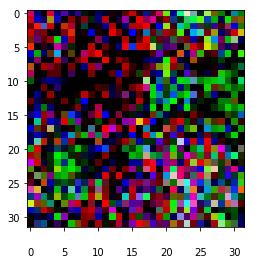

  6%|▌         | 1000/18000 [24:17<6:52:54,  1.46s/it]

loss:  0.826406
[-1  1 -1  1 -1  1 -1 -1  1  1]


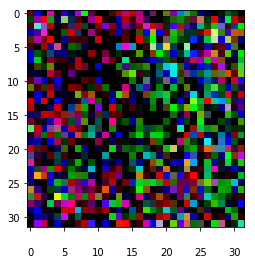

 11%|█         | 2000/18000 [48:35<6:28:47,  1.46s/it]

loss:  0.16526
[ 1 -1  1  1 -1  1 -1  1  1  1]


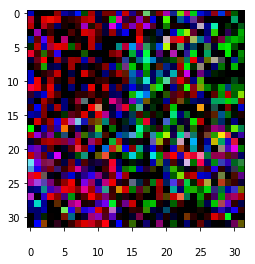

 17%|█▋        | 3000/18000 [1:12:55<6:04:35,  1.46s/it]

loss:  0.0133518
[ 1 -1 -1 -1  1  1  1 -1 -1 -1]


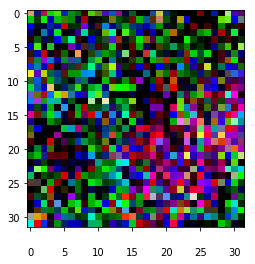

 22%|██▏       | 4000/18000 [1:37:13<5:40:16,  1.46s/it]

loss:  0.00808563
[ 1  1  1  1 -1 -1  1  1  1 -1]


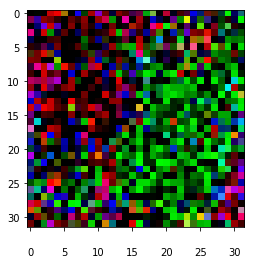

 28%|██▊       | 5000/18000 [2:01:42<5:16:26,  1.46s/it]

loss:  0.00663511
[ 1  1  1  1  1  1 -1 -1 -1  1]


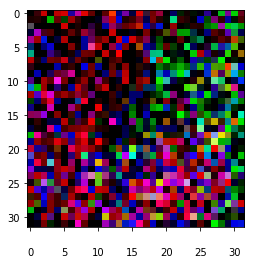

 33%|███▎      | 6000/18000 [2:26:05<4:52:10,  1.46s/it]

loss:  0.0133017
[ 1  1 -1  1  1 -1  1  1 -1 -1]


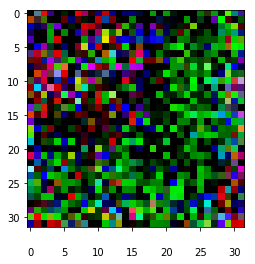

 35%|███▍      | 6253/18000 [2:32:24<4:46:19,  1.46s/it]


KeyboardInterrupt: 

In [149]:
#missing Trainable batch norm thingy
for i in tqdm(range(200 * 90)):
    batch_ = np.random.randint(9000, size=200)
    x = sess.run([train, loss, merged], feed_dict={input_ : input_data[batch_, :], isTraining : True})
    if i % 50 == 0:
        writer.add_summary(x[2], i)

    if i % 1000 == 0:
        x = sess.run([loss], feed_dict={input_ : val_data, isTraining : False})
        print('loss: ', x[0])
        check_data = np.random.choice([-1, 1], size=(1, 10))
        print(check_data[0])
        image_output = sess.run([dense_layer1], feed_dict={input_ : check_data, isTraining : False})
        image_output1 = np.reshape(image_output[0], (output_image, output_image, 3))
        plt.figure(figsize=(4, 4))
        plt.imshow(image_output1)

        plt.show(image_output)



In [153]:
check_data = np.random.choice([-1, 1], size=(1, 10))
print(check_data[0])
image_output = sess.run([fc2], feed_dict={input_ : check_data, isTraining : False})
print(np.sign(image_output[0][0]))
# image_output1 = np.reshape(image_output[0], (output_image, output_image, 3))
# plt.figure(figsize=(4, 4))
# plt.imshow(image_output1)

# plt.show(image_output)
# print(np.sign(image_output[0][0]))
# image_output1 = np.reshape(image_output[0], (output_image, output_image, 3))
# plt.imshow(image_output1)

# print(sess.run([fc2], feed_dict={input_ : check_data, isTraining: False}))

[-1  1  1  1 -1 -1  1  1  1 -1]
[-1.  1.  1.  1. -1. -1.  1.  1.  1. -1.]
